In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from os.path import dirname, join as pjoin
import scipy.io as sio
import h5py
import hdf5storage
import random
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from PIL import Image
from matplotlib.image import imread
import os
from tensorflow.keras import applications

In [2]:
PATH_TO_TRAIN = '/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs'
PATH_TO_TEST = '/home/maxim/Desktop/ml_dataset/dogs-cats/test_imgs'

In [3]:
def show_random_imgs(path_to):    
    fig = plt.figure(figsize = (15, 15))
    for i in range(1, 5):
        image_path = path_to + str(random.randrange(0, 12499)) + '.jpg'
        image = imread(image_path)
        plot = fig.add_subplot(2,4,i)
        plot.imshow(image)
    plt.show()
    plt.close()

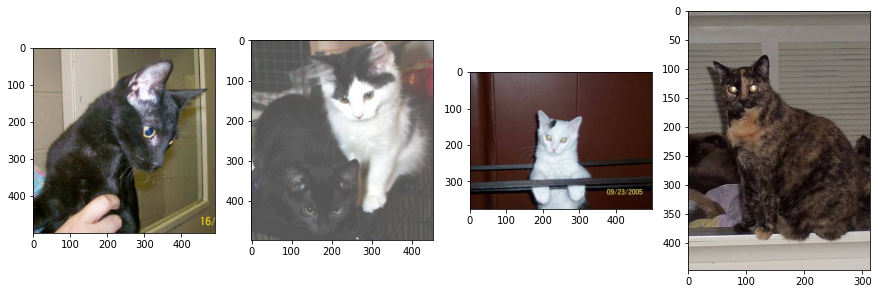

In [4]:
show_random_imgs('/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs/cats/cat.')

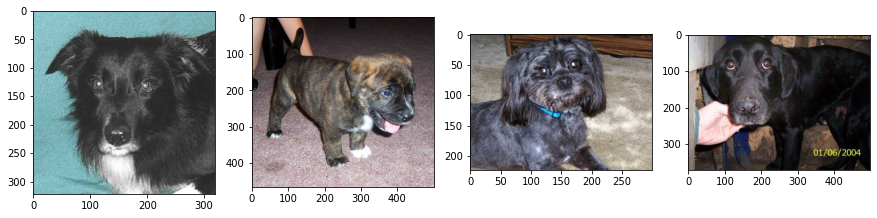

In [5]:
show_random_imgs('/home/maxim/Desktop/ml_dataset/dogs-cats/train_imgs/dogs/dog.')

In [6]:
# DEFINE CLASSIC SETS

VALIDATION_SET_RATE = 0.03
BATCH_SIZE = 128
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
EPOCHS_COUNT = 5

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

train_data_gen = image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training',
                                                     class_mode='binary')
STEPS_PER_EPOCH_TRAIN = np.ceil(train_data_gen.samples/BATCH_SIZE)

validation_data_gen = image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation',
                                                     class_mode='binary')

STEPS_PER_EPOCH_VALIDATION = np.ceil(validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [13]:
# DEFINE AUGUMENTED SETS

augumented_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    horizontal_flip=True,
    validation_split=VALIDATION_SET_RATE
)

au_train_data_gen = augumented_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='training',
                                                     class_mode='binary')
AU_STEPS_PER_EPOCH_TRAIN = np.ceil(au_train_data_gen.samples/BATCH_SIZE)

au_validation_data_gen = augumented_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     subset='validation',
                                                     class_mode='binary')

AU_STEPS_PER_EPOCH_VALIDATION = np.ceil(au_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [8]:
# DEFINE THE MODEL

input_layer = layers.Input(shape=((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
conv_1 = layers.Conv2D(16, kernel_size=(3, 3), padding='valid')
conv_2 = layers.Conv2D(32, kernel_size=(3, 3), padding='valid')
conv_3 = layers.Conv2D(64, kernel_size=(3, 3), padding='valid')
mp_1 = layers.MaxPooling2D(strides=(2, 2))
mp_2 = layers.MaxPooling2D(strides=(2, 2))
mp_3 = layers.MaxPooling2D(strides=(2, 2))

fc_1 = layers.Dense(128, activation='relu')
fc_2 = layers.Dense(64, activation='relu')

out_layer = layers.Dense(1, activation='sigmoid')

model = keras.Sequential([
        input_layer,
        conv_1,
        mp_1,
#         layers.Dropout(0.2),
        conv_2,
        mp_2,
#         layers.Dropout(0.2),
        conv_3,
        mp_3,
#         layers.Dropout(0.2),
        layers.Flatten(),
        fc_1,
#         layers.Dropout(0.4),
        fc_2,
        out_layer
    ])
model.summary()

model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

In [9]:
keras.backend.clear_session()

if os.path.exists('three_conv.h5'):
    model = load_model('three_conv.h5')
else:
    history = model.fit_generator(
        train_data_gen,
        validation_data=validation_data_gen,
        steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        epochs=EPOCHS_COUNT,
        verbose=1
    )
    model.save('three_conv.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 190.0 steps, validate for 6.0 steps
Epoch 1/5
190/190 [==============================] - 138s 728ms/step - loss: 0.6715 - accuracy: 0.5815 - val_loss: 0.6774 - val_accuracy: 0.5680
Epoch 2/5
190/190 [==============================] - 145s 764ms/step - loss: 0.6463 - accuracy: 0.6261 - val_loss: 0.6329 - val_accuracy: 0.6280
Epoch 3/5
190/190 [==============================] - 143s 751ms/step - loss: 0.6306 - accuracy: 0.6443 - val_loss: 0.6201 - val_accuracy: 0.6440
Epoch 4/5
190/190 [==============================] - 139s 730ms/step - loss: 0.6101 - accuracy: 0.6662 - val_loss: 0.6062 - val_accuracy: 0.6533
Epoch 5/5
190/190 [==============================] - 142s 747ms/step - loss: 0.5917 - accuracy: 0.6854 - val_loss: 0.5967 - val_accuracy: 0.6693


In [15]:
au_input_layer = layers.Input(shape=((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
au_conv_1 = layers.Conv2D(16, kernel_size=(3, 3), padding='valid')
au_conv_2 = layers.Conv2D(32, kernel_size=(3, 3), padding='valid')
au_conv_3 = layers.Conv2D(64, kernel_size=(3, 3), padding='valid')
au_mp_1 = layers.MaxPooling2D(strides=(2, 2))
au_mp_2 = layers.MaxPooling2D(strides=(2, 2))
au_mp_3 = layers.MaxPooling2D(strides=(2, 2))

au_fc_1 = layers.Dense(128, activation='relu')
au_fc_2 = layers.Dense(64, activation='relu')

au_out_layer = layers.Dense(1, activation='sigmoid')

au_model = keras.Sequential([
        au_input_layer,
        au_conv_1,
        au_mp_1,
#         layers.Dropout(0.2),
        au_conv_2,
        au_mp_2,
#         layers.Dropout(0.2),
        au_conv_3,
        au_mp_3,
#         layers.Dropout(0.2),
        layers.Flatten(),
        au_fc_1,
#         layers.Dropout(0.4),
        au_fc_2,
        au_out_layer
    ])
au_model.summary()

au_model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)            

In [16]:
if os.path.exists('three_conv_au.h5'):
    au_model = load_model('three_conv_au.h5')
else:
    au_history = au_model.fit_generator(
        au_train_data_gen,
        validation_data=au_validation_data_gen,
        steps_per_epoch=AU_STEPS_PER_EPOCH_TRAIN,
        validation_steps=AU_STEPS_PER_EPOCH_VALIDATION,
        epochs=EPOCHS_COUNT,
        verbose=1
    )
    au_model.save('three_conv_au.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 190.0 steps, validate for 6.0 steps
Epoch 1/5
190/190 [==============================] - 204s 1s/step - loss: 0.6830 - accuracy: 0.5581 - val_loss: 0.6764 - val_accuracy: 0.5493
Epoch 2/5
190/190 [==============================] - 187s 983ms/step - loss: 0.6694 - accuracy: 0.5895 - val_loss: 0.6704 - val_accuracy: 0.5680
Epoch 3/5
190/190 [==============================] - 187s 986ms/step - loss: 0.6616 - accuracy: 0.6018 - val_loss: 0.6527 - val_accuracy: 0.6160
Epoch 4/5
190/190 [==============================] - 191s 1s/step - loss: 0.6575 - accuracy: 0.6085 - val_loss: 0.6459 - val_accuracy: 0.6227
Epoch 5/5
190/190 [==============================] - 184s 969ms/step - loss: 0.6494 - accuracy: 0.6212 - val_loss: 0.6531 - val_accuracy: 0.6133


In [17]:
# On classic 3-conv
model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 2s 276ms/step - loss: 0.6347 - accuracy: 0.6013


[0.634708821773529, 0.6013333]

In [18]:
# On augumented 3-conv
au_model.evaluate(validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 2s 277ms/step - loss: 0.6257 - accuracy: 0.6613


[0.6257199943065643, 0.6613333]

In [27]:
# VGG-16
keras.backend.clear_session()
    
# Load model and mark pretrained layers as not trainable
vgg16 = applications.VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False
        
# Forward pretrained model output into new layers
x = layers.Flatten()(vgg16.layers[-1].output)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)
    
# Compile model
vgg16 = keras.Model(inputs=vgg16.inputs, outputs=output)
vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

vgg_train_data_gen = vgg_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='training',
                                                     class_mode='binary')
VGG_STEPS_PER_EPOCH_TRAIN = np.ceil(vgg_train_data_gen.samples/BATCH_SIZE)

vgg_validation_data_gen = vgg_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='validation',
                                                     class_mode='binary')

VGG_STEPS_PER_EPOCH_VALIDATION = np.ceil(vgg_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [29]:
if os.path.exists('vgg16.h5'):
    vgg16 = load_model('vgg16.h5')
else:
    vgg_history = vgg16.fit_generator(
        vgg_train_data_gen,
        validation_data=vgg_validation_data_gen,
        steps_per_epoch=VGG_STEPS_PER_EPOCH_TRAIN,
        validation_steps=VGG_STEPS_PER_EPOCH_VALIDATION,
        epochs=1,
        verbose=1
    )
    vgg16.save('vgg16.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 190.0 steps, validate for 6.0 steps
190/190 [==============================] - 4118s 22s/step - loss: 0.2542 - accuracy: 0.8921 - val_loss: 0.1880 - val_accuracy: 0.9267


In [31]:
# On VGG-16
vgg16.evaluate(vgg_validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 120s 20s/step - loss: 0.1880 - accuracy: 0.9267


[0.18797416488329569, 0.9266667]

In [36]:
# RESNET
keras.backend.clear_session()
    
# Load model and mark pretrained layers as not trainable
resnet = applications.resnet.ResNet50(include_top=False, input_shape=(224, 224, 3))
for layer in resnet.layers:
    layer.trainable = False
        
# Forward pretrained model output into new layers
x1 = layers.Flatten()(resnet.layers[-1].output)
x1 = layers.Dense(128, activation='relu')(x1)
output1 = layers.Dense(1, activation='sigmoid')(x1)
    
# Compile model
resnet = keras.Model(inputs=resnet.inputs, outputs=output1)
resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

resnet_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SET_RATE
)

resnet_train_data_gen = resnet_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='training',
                                                     class_mode='binary')
RESNET_STEPS_PER_EPOCH_TRAIN = np.ceil(resnet_train_data_gen.samples/BATCH_SIZE)

resnet_validation_data_gen = resnet_image_generator.flow_from_directory(directory=str(PATH_TO_TRAIN),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     subset='validation',
                                                     class_mode='binary')

RESNET_STEPS_PER_EPOCH_VALIDATION = np.ceil(resnet_validation_data_gen.samples/BATCH_SIZE)

Found 24250 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [40]:
if os.path.exists('resnet.h5'):
    resnet = load_model('resnet.h5')
else:
    resnet_history = resnet.fit_generator(
        resnet_train_data_gen,
        validation_data=resnet_validation_data_gen,
        steps_per_epoch=RESNET_STEPS_PER_EPOCH_TRAIN,
        validation_steps=RESNET_STEPS_PER_EPOCH_VALIDATION,
        epochs=1,
        verbose=1
    )
    resnet.save('resnet.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 190.0 steps, validate for 6.0 steps
190/190 [==============================] - 1582s 8s/step - loss: 0.5571 - accuracy: 0.9509 - val_loss: 0.7730 - val_accuracy: 0.5013


In [42]:
# On RESNET
resnet.evaluate(resnet_validation_data_gen)

  ...
    to  
  ['...']
6/6 [==============================] - 33s 6s/step - loss: 0.7730 - accuracy: 0.5013


[0.7729676167170206, 0.50133336]